# Calculate Dislocation

In [1]:
import geopandas as gpd

vtds = gpd.read_file("../00_source_data/alarmshape 2021-10-07.shp")


In [2]:
vtds.columns


Index(['ID', 'STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'VTDI20',
       'NAME20', 'NAMELSAD20', 'LSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20',
       'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'OID_', 'GEOID20_1', 'RVPRE20',
       'DVPRE20', 'TPTYPRE20', 'RVPRES16', 'DVPRES16', 'TPTYPR16', 'RVUSS16',
       'DVUSS16', 'TPTYUSS16', 'STATEFP', 'COUNTYFP', 'DISTRICT', 'G18USSRREN',
       'G18USSDBRO', 'G18GOVRDEW', 'G18GOVDCOR', 'G18GOVLIRV', 'G18GOVGGAD',
       'G18ATGRYOS', 'G18ATGDDET', 'G18AUDRFAB', 'G18AUDDSPA', 'G18AUDLCOO',
       'G18SOSRLAR', 'G18SOSDCLY', 'G18SOSLNAN', 'G18TRERSPR', 'G18TREDRIC',
       'RVUSS18', 'DVUSS18', 'TPTYUSS18', 'RVGOV18', 'DVGOV18', 'TPTYGOV18',
       'RVATG18', 'DVATG18', 'TPTYATG18', 'RVAUD18', 'DVAUD18', 'TPTYAUD18',
       'RVSOS18', 'DVSOS18', 'TPTYSOS18', 'RVTRE18', 'DVTRE18', 'TPTYTRE18',
       'geometry'],
      dtype='object')

## Calc vote shares


In [3]:
elections = [
    "PRE20",
    "PRES16",
    "USS16",
    "USS18",
    "GOV18",
    "ATG18",
    "AUD18",
    "SOS18",
    "TRE18",
]

for p in ["D", "R"]:
    vtds[f"{p}_count"] = 0
    for e in elections:
        vtds[f"{p}_count"] += vtds[p + "V" + e]
    vtds[f"{p}_count"] = vtds[f"{p}_count"] / len(elections)


## Sanity Checks

<AxesSubplot:>

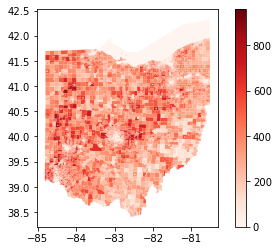

In [4]:
vtds.plot("R_count", cmap="Reds", legend=True)


<AxesSubplot:>

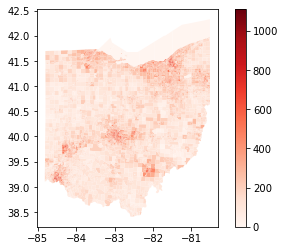

In [5]:
vtds.plot("D_count", cmap="Reds", legend=True)


In [6]:
vtds["D_count"].sum() / (vtds["D_count"].sum() + vtds["R_count"].sum())


0.46786351183282615

In [7]:
(vtds["D_count"].sum() + vtds["R_count"].sum())


4669177.466499511

## Create Representative Voters

In [8]:
import partisan_dislocation as pdn

vtds = vtds.to_crs(epsg=26917)
voters = pdn.random_points_in_polygon(
    vtds, p=0.07, dem_vote_count="D_count", repub_vote_count="R_count"
)


In [9]:
len(voters)


326611

<AxesSubplot:>

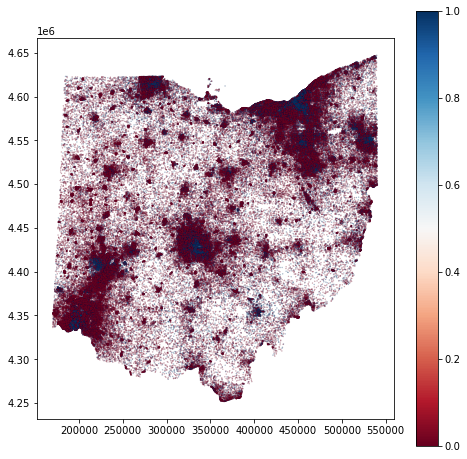

In [10]:
voters.plot("dem", cmap="RdBu", markersize=0.1, alpha=0.5, figsize=(8, 8), legend=True)


## Now KNN. 

In [11]:
num_dists = len(
    gpd.read_file(f"../00_source_data/round2_2021_11_22/challenged_daves.shp")
)


In [12]:
num_dists


15

In [13]:
knn = pdn.calculate_voter_knn(voters, k=len(voters) / num_dists, target_column="dem")


## Dislocation


In [14]:
districts = {}
files = {
    "challenged": "challenged_daves",
    "housedems": "housedems_congress_11_5_21",
    "ocrc": "ocrc_09_30_21",
    "senatedems": "sendems_congress_11_10_21",
}
authors = files.keys()

for a in authors:
    districts[a] = gpd.read_file(f"../00_source_data/round2_2021_11_22/{files[a]}.shp")
    districts[a] = districts[a].to_crs(epsg=26917)
    assert len(districts[a]) == num_dists


In [15]:
authors


dict_keys(['challenged', 'housedems', 'ocrc', 'senatedems'])

In [16]:
import numpy as np

knn = knn.to_crs(epsg=26917)

dislocation_points = {}
dislocation_dists = {}
for a in authors:
    df = pdn.calculate_dislocation(
        knn,
        districts[a],
        knn_column="knn_shr_dem",
        dem_column="dem",
        district_id_col="DISTRICT",
    )
    df = df.to_crs(epsg=26917)
    df.loc[:, "abs_partisan_dislocation"] = np.abs(df["partisan_dislocation"])
    dislocation_points[a] = df


For map by challenged:
Avg absolute dislocation over all voters is 0.0756
Most dislocated district for challenged has avg dislocation of 0.149
For map by housedems:
Avg absolute dislocation over all voters is 0.0676
Most dislocated district for housedems has avg dislocation of 0.118
For map by ocrc:
Avg absolute dislocation over all voters is 0.0652
Most dislocated district for ocrc has avg dislocation of 0.121
For map by senatedems:
Avg absolute dislocation over all voters is 0.0651
Most dislocated district for senatedems has avg dislocation of 0.155


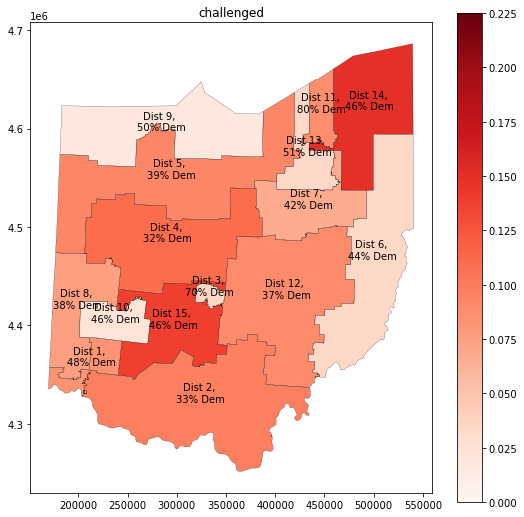

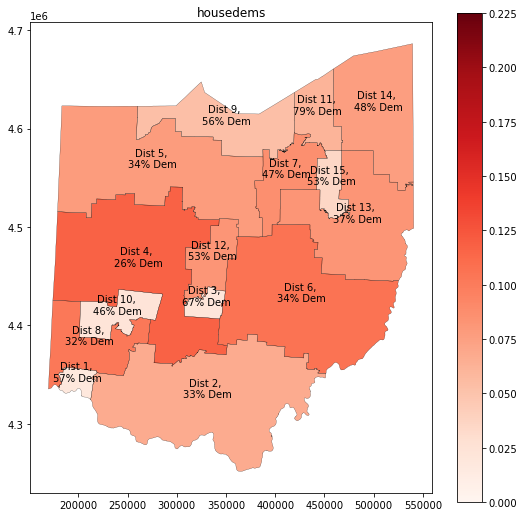

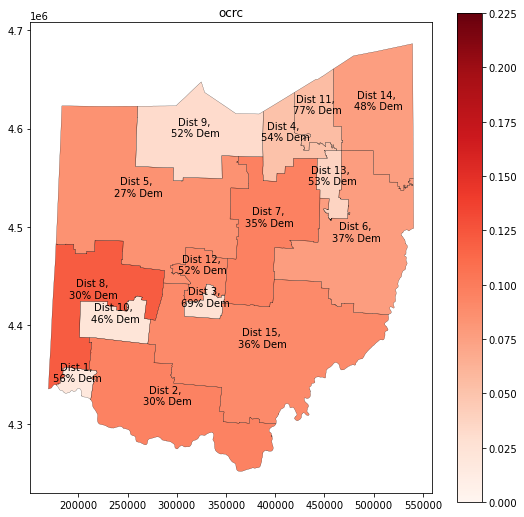

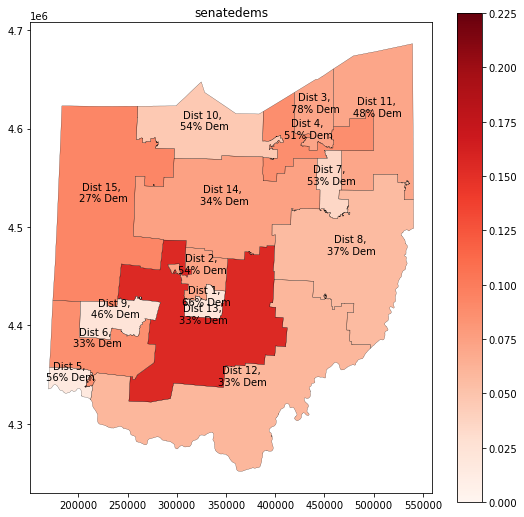

In [17]:
import pandas as pd

for a in authors:
    df = dislocation_points[a]
    print(f"For map by {a}:")
    print(
        f"Avg absolute dislocation over all voters is {df.abs_partisan_dislocation.mean():0.4f}"
    )

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["abs_partisan_dislocation", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    print(
        f"Most dislocated district for {a} has avg dislocation of {dist.abs_partisan_dislocation.max():0.3f}"
    )

    ax = dist.plot(
        "abs_partisan_dislocation",
        cmap="Reds",
        legend=True,
        figsize=(9, 9),
        vmin=0,
        vmax=0.225,
    )
    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    dist.boundary.plot(edgecolor="black", ax=ax, linewidth=0.2)
    ax.set_title(a)
    ax.figure.savefig(f"../30_results/{a}_districts.png")


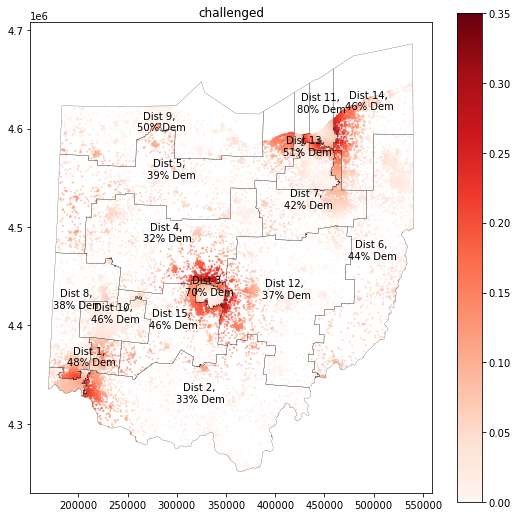

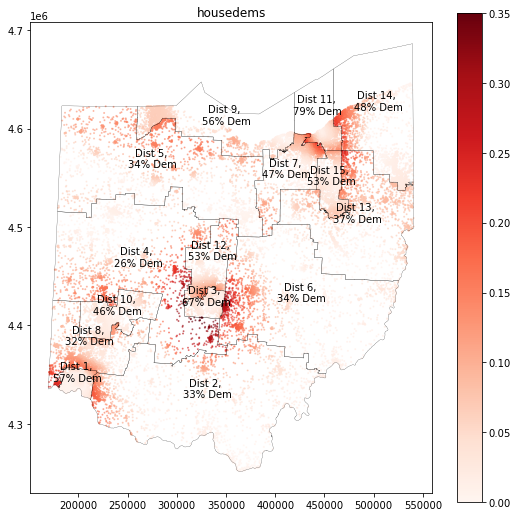

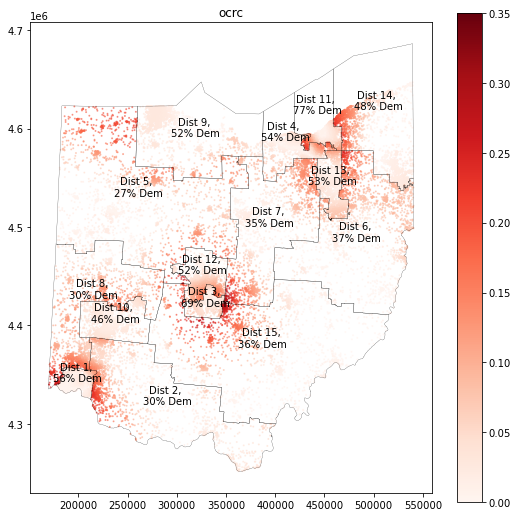

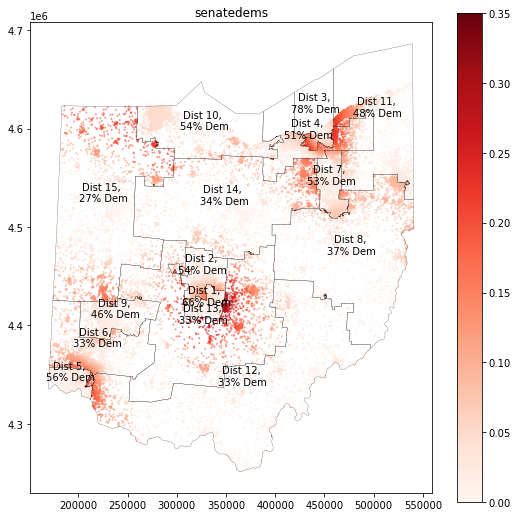

In [18]:
for a in authors:
    df = dislocation_points[a]
    ax = df.sample(frac=0.1).plot(
        "abs_partisan_dislocation",
        cmap="Reds",
        legend=True,
        figsize=(9, 9),
        vmin=0,
        vmax=0.35,
        markersize=1,
        alpha=0.5,
    )
    ax.set_title(a)

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["abs_partisan_dislocation", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    dist.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2)

    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    ax.figure.savefig(f"../30_results/{a}_points.png")
